## DSC550 Week 5: Classification Models and Clustering

#### Bryan Rogers
#### Bellevue University
#### DSC550: Data Mining
#### 12/11/23

### 5.2 Exercise: Build your own Sentiment Analysis Model

#### 1. Get the stemmed data using the same process you did in Week 3.

In [1]:
# Import necessary libraries
import nltk
import sklearn
import pandas as pd
import numpy as np
import yellowbrick
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load movie review data into a DataFrame
df = pd.read_csv('labeledTrainData.tsv', delimiter='\t')

In [4]:
# Check if the data is loaded properly
print(df.head(5))

       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...


In [5]:
# Use TextBlob to classify each movie review as positive or negative
def classify_sentiment(text):
    analysis = TextBlob(text)
    return 1 if analysis.sentiment.polarity >= 0 else 0

# Apply TextBlob sentiment analysis to the 'review' column
df['predicted_sentiment'] = df['review'].apply(classify_sentiment)

In [6]:
# Check the accuracy of the model
accuracy = accuracy_score(df['sentiment'], df['predicted_sentiment'])
print("Accuracy of TextBlob model:", accuracy)

Accuracy of TextBlob model: 0.68524


In [7]:
# Download NLTK resources (stopwords)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bryansmacbookpro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# Convert to lowercase
df['processed_review'] = df['review'].apply(lambda x: x.lower())

In [9]:
# Remove punctuation and special characters
df['processed_review'] = df['processed_review'].apply(lambda x: ''.join([char for char in x if char.isalnum() or char.isspace()]))

In [10]:
# Remove stop words
stop_words = set(stopwords.words('english'))
df['processed_review'] = df['processed_review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [11]:
ps = PorterStemmer()
df['processed_review'] = df['processed_review'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

In [12]:
df.head(5)

id  sentiment                                             review  \
0  5814_8          1  With all this stuff going down at the moment w...   
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...   
2  7759_3          0  The film starts with a manager (Nicholas Bell)...   
3  3630_4          0  It must be assumed that those who praised this...   
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...   

   predicted_sentiment                                   processed_review  
0                    1  stuff go moment mj ive start listen music watc...  
1                    1  classic war world timothi hine entertain film ...  
2                    0  film start manag nichola bell give welcom inve...  
3                    1  must assum prais film greatest film opera ever...  
4                    0  superbl trashi wondrous unpretenti 80 exploit ...

In [13]:
df.shape

(25000, 5)

In [14]:
df.dtypes

id                     object
sentiment               int64
review                 object
predicted_sentiment     int64
processed_review       object
dtype: object

#### 2. Split this into a training and test set.

In [15]:
# Create a training and test dataset
X = df['processed_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Print the shapes of the test and training data sets
print(X_train.shape)
print(X_test.shape)

(20000,)
(5000,)


#### 3. Fit and apply the tf-idf vectorization to the training set.

In [17]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_train_tfidf.shape

(20000, 80823)

#### 4. Apply but DO NOT FIT the tf-idf vectorization to the test set (Why?).

In [18]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_test_tfidf.shape

(5000, 80823)

I fit the vectorizer on the training set to learn the vocabulary and TF-IDF values, and then applied the same vectorizer (without re-fitting) to the test set to maintain consistency and evaluate the model's generalization performance on unseen data.

#### 5. Train a logistic regression using the training data.

In [19]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train_tfidf, y_train)

LogisticRegression()

#### 6. Find the model accuracy on test set.

In [20]:
y_pred = logreg_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8874


#### 7. Create a confusion matrix for the test set predictions.

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[2163  318]
 [ 245 2274]]


#### 8. Get the precision, recall, and F1-score for the test set predictions.

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1-score: {f1:.4f}')

Precision: 0.8773
Recall: 0.9027
F1-score: 0.8898


#### 9. Create a ROC curve for the test set.

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, logreg_model.predict_proba(X_test_tfidf)[:, 1])
roc_auc = auc(fpr, tpr)

print(f"ROC Curve:\n{roc_auc}")

ROC Curve:
0.9556227167681206


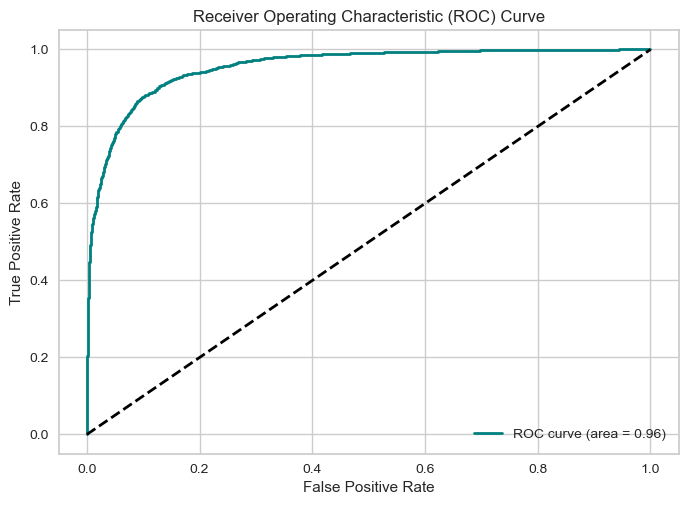

In [24]:
plt.figure()
plt.plot(fpr, tpr, color='teal', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### 10. Pick another classification model you learned about this week and repeat steps (5) – (9).

In [25]:
from sklearn.svm import SVC

In [ ]:
# Step 4: Train a Support Vector Machine (SVM) Model
svm_model = SVC(probability=True)  # probability=True for ROC curve later
svm_model.fit(X_train_tfidf, y_train)

svm_model.shape

In [ ]:
# Step 5: Evaluate SVM Model Accuracy
y_pred_svm = svm_model.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Model Accuracy: {accuracy_svm}")

In [ ]:
# Step 6: Create a Confusion Matrix for SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(f"SVM Confusion Matrix:\n{conf_matrix_svm}")

In [ ]:
# Step 7: Calculate Precision, Recall, and F1-score for SVM
# Calculate Precision
precision = precision_score(y_test, y_pred_svm)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred_svm)
print(f'Recall: {recall:.4f}')

# Calculate F1-score
f1 = f1_score(y_test, y_pred_svm)
print(f'F1-score: {f1:.4f}')

In [ ]:
# Step 8: Create a ROC Curve for SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_model.predict_proba(X_test_tfidf)[:, 1])
roc_auc_svm = auc(fpr_svm, tpr_svm)

In [ ]:
# Plot ROC curve for SVM
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend(loc="lower right")
plt.show()